### Section 1: Importing Required Libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro
from prettytable import PrettyTable
from scipy.stats import wilcoxon, ranksums
from statsmodels.stats import multitest 
from matplotlib_venn import venn2
from gseapy.plot import gseaplot
import gseapy as gp
import csv

### Section 2: Loading and Validating Datasets

In [2]:
# Load cancer and healthy tissue data
cancer_file_path = 'G:\\Fourth Year\\Bioinformatics\\OurProject\\lusc-rsem-fpkm-tcga-t_paired.txt'
healthy_file_path = 'G:\\Fourth Year\\Bioinformatics\\OurProject\\lusc-rsem-fpkm-tcga_paired.txt'

cancer_data = pd.read_csv(cancer_file_path, sep='\t')
healthy_data = pd.read_csv(healthy_file_path, sep='\t')

# Display the first few rows to ensure correct loading
print("Cancer Data Sample:")
print(cancer_data.head())

print("\nHealthy Data Sample:")
print(healthy_data.head())

# Data Validation
# Ensure genes match
assert all(cancer_data['Hugo_Symbol'] == healthy_data['Hugo_Symbol']), "Gene symbols do not match!"
assert all(cancer_data['Entrez_Gene_Id'] == healthy_data['Entrez_Gene_Id']), "Entrez IDs do not match!"

# Verify patient columns align
patient_columns = cancer_data.columns[2:]  # Skip 'Hugo_Symbol' and 'Entrez_Gene_Id'
assert list(patient_columns) == list(healthy_data.columns[2:]), "Patient columns do not match!"

# Check for missing values
missing_cancer = cancer_data.isnull().sum().sum()
missing_healthy = healthy_data.isnull().sum().sum()

print("Missing values in cancer data:", missing_cancer)
print("Missing values in healthy data:", missing_healthy)

# Drop rows with missing values if necessary
cancer_data_clean = cancer_data.dropna()
healthy_data_clean = healthy_data.dropna()

print("\nCancer data after cleaning:")
print(cancer_data_clean.head())

print("\nHealthy data after cleaning:")
print(healthy_data_clean.head())


Cancer Data Sample:
  Hugo_Symbol  Entrez_Gene_Id  TCGA-43-7657  TCGA-58-8386  TCGA-22-5478  \
0    HIST3H2A           92815        336.79        500.46        703.28   
1       LIN7B           64130        105.15        212.78        102.25   
2         LXN           56925        848.22        236.21        271.48   
3      CNKSR2           22866         32.59          8.51         45.85   
4       SCML1            6322         84.63         74.58         67.12   

   TCGA-22-5472  TCGA-43-5670  TCGA-60-2709  TCGA-22-5489  TCGA-77-8007  ...  \
0        287.01        486.75         70.51        145.02         14.03  ...   
1        212.78        172.65        244.57        105.89        152.28  ...   
2        759.08         61.25        620.67        329.84        599.49  ...   
3          6.16         49.21         11.91         12.27         15.00  ...   
4         57.89        102.97        132.44         66.65         57.08  ...   

   TCGA-85-7710  TCGA-56-7580  TCGA-43-6647  TCG

### Statistical Summary

In [3]:
# Statistical summary for cancer and healthy datasets
print("Cancer Data Statistics:")
print(cancer_data.iloc[:, 2:].describe())  # Skipping 'Hugo_Symbol' and 'Entrez_Gene_Id'

print("\nHealthy Data Statistics:")
print(healthy_data.iloc[:, 2:].describe())

Cancer Data Statistics:
        TCGA-43-7657   TCGA-58-8386   TCGA-22-5478   TCGA-22-5472  \
count   19648.000000   19648.000000   19648.000000   19648.000000   
mean     1092.378349    1085.476443     949.410639    1006.856298   
std      6368.175689    6504.825637    4539.572180    5118.938654   
min         0.000000       0.000000       0.000000       0.000000   
25%         9.340000      12.000000      13.320000      12.550000   
50%       147.060000     175.070000     164.420000     177.530000   
75%       591.220000     638.150000     629.350000     633.730000   
max    234624.450000  237899.700000  212926.090000  160252.910000   

        TCGA-43-5670   TCGA-60-2709   TCGA-22-5489   TCGA-77-8007  \
count   19648.000000   19648.000000   19648.000000   19648.000000   
mean     1087.339815    1147.483954    1094.388318     998.750478   
std      5985.528884    7913.010986    6589.650416    5645.171003   
min         0.000000       0.000000       0.000000       0.000000   
25%      

### Section 4: Visualizing Gene Expression

C:\Users\3m\AppData\Local\Temp\ipykernel_19060\1159171258.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cancer_gene_data, healthy_gene_data], labels=['Cancer', 'Healthy'])


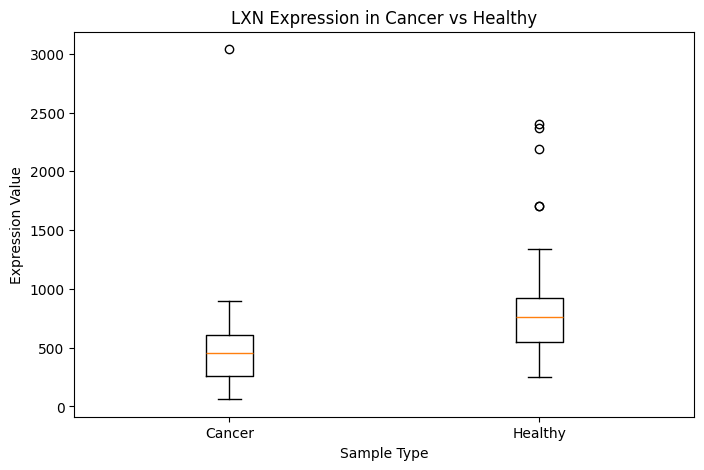

In [4]:
# Example gene for visualization
example_gene = 'LXN'  # Replace with any gene from Hugo_Symbol column

# Extract gene data for cancer and healthy tissue
cancer_gene_data = cancer_data.loc[cancer_data['Hugo_Symbol'] == example_gene].iloc[:, 2:].values.flatten()
healthy_gene_data = healthy_data.loc[healthy_data['Hugo_Symbol'] == example_gene].iloc[:, 2:].values.flatten()

# Create box plot
plt.figure(figsize=(8, 5))
plt.boxplot([cancer_gene_data, healthy_gene_data], labels=['Cancer', 'Healthy'])
plt.title(f'{example_gene} Expression in Cancer vs Healthy')
plt.ylabel('Expression Value')
plt.xlabel('Sample Type')
plt.show()

### Section 5: Concatenating Expression Levels

In [5]:
# Initialize a dictionary to store expression levels with gene names as keys
exprLung_data = {}

# Iterate through all genes and store expression levels
for gene in cancer_data['Hugo_Symbol']:
    normalLung_expression = healthy_data[healthy_data['Hugo_Symbol'] == gene].iloc[:, 2:].values.flatten()
    cancerousLung_expression = cancer_data[cancer_data['Hugo_Symbol'] == gene].iloc[:, 2:].values.flatten()
    exprLung_data[gene] = {
        'Normal': normalLung_expression,
        'Cancerous': cancerousLung_expression
    }

# Display a sample of concatenated expression levels
print("Sample of concatenated expression levels:")
table = PrettyTable()
table.field_names = ["Gene", "Normal Expression", "Cancerous Expression"]

# Display data for the first 5 genes
for i, (gene, expression_data) in enumerate(exprLung_data.items()):
    if i >= 5:
        break
    table.add_row([gene, expression_data['Normal'], expression_data['Cancerous']])

print(table)

Sample of concatenated expression levels:
+----------+--------------------------------------------------------------------------+--------------------------------------------------------------------------+
|   Gene   |                            Normal Expression                             |                           Cancerous Expression                           |
+----------+--------------------------------------------------------------------------+--------------------------------------------------------------------------+
| HIST3H2A |  [ 62.12 130.6   33.06  35.5   73.03  60.39  92.05  66.65  54.33  15.56  | [ 336.79  500.46  703.28  287.01  486.75   70.51  145.02   14.03  397.93 |
|          |    55.49  30.34  14.45 100.83 131.51  59.55  87.03  71.5   23.08  48.87  |   318.57  463.65    6.78  242.88  135.24  363.56  231.32  403.5   136.19 |
|          |    72.52 115.97  45.21  74.58   8.92  27.44  40.64  35.76  59.13  20.86  |   130.6   285.03  156.59  954.43  454.09  110.43   16.5

### Section 6: Handling Null Values

In [6]:
# Filter out genes with more than 50% zeros
genes_with_more_than_50_percent_zeros = []

for gene, expression_data in exprLung_data.items():
    normal_zeros = len(expression_data['Normal'][expression_data['Normal'] == 0])
    cancerous_zeros = len(expression_data['Cancerous'][expression_data['Cancerous'] == 0])

    if (normal_zeros / len(expression_data['Normal']) >= 0.5 or 
        cancerous_zeros / len(expression_data['Cancerous']) >= 0.5):
        genes_with_more_than_50_percent_zeros.append(gene)

# Filter and store the data
exprLung_data_filtered = {
    gene: data for gene, data in exprLung_data.items() if gene not in genes_with_more_than_50_percent_zeros
}
exprLung_data_removed = {
    gene: data for gene, data in exprLung_data.items() if gene in genes_with_more_than_50_percent_zeros
}

# Display summary of filtering
print(f"Filtered genes: {len(exprLung_data_filtered)}")
print(f"Removed genes: {len(exprLung_data_removed)}")

Filtered genes: 17284
Removed genes: 2364


### Section 7: Calculating Differences

In [7]:
# Calculate differences between cancerous and normal expression levels
exprLung_differences = []

for gene, expression_data in exprLung_data_filtered.items():
    differences = expression_data['Cancerous'] - expression_data['Normal']
    exprLung_differences.append((gene, differences))

# Display sample differences
print("Sample differences between normal and cancerous expression levels:")
table = PrettyTable()
table.field_names = ["Gene", "Differences"]

for gene, differences in exprLung_differences[:5]:
    table.add_row([gene, differences])

print(table)

Sample differences between normal and cancerous expression levels:
+----------+--------------------------------------------------------------------------+
|   Gene   |                               Differences                                |
+----------+--------------------------------------------------------------------------+
| HIST3H2A | [ 274.67  369.86  670.22  251.51  413.72   10.12   52.97  -52.62  343.6  |
|          |   303.01  408.16  -23.56  228.43   34.41  232.05  171.77  316.47   64.69 |
|          |   107.52  236.16   84.07  838.46  408.88   35.85    7.59  420.38   63.05 |
|          |   151.95   68.76  697.22  799.48   50.55   28.86  210.82  125.08  201.47 |
|          |   316.45  268.44   38.99   45.2   -87.71  361.13   69.59   83.71 1203.84 |
|          |                   90.36  298.74  190.81  207.85  -53.66]                 |
|  LIN7B   | [ -79.96  -70.27  -17.01   43.71    7.08   83.55  -25.62  -46.19   83.5  |
|          |    71.73   98.51  115.22  143.76  -32.23

### Section 8: Performing Shapiro-Wilk Normality Test (Paired samples)


In [8]:
# Initialize lists
normal_genes = []
non_normal_genes = []

def normality_test(gene, data, alpha=0.05):
    """
    Perform Shapiro-Wilk test for normality on the given data.

    Parameters:
    gene (str): The name of the gene being tested.
    data (array-like): The data sample to test for normality.
    alpha (float, optional): The significance level for the test. Defaults to 0.05.

    Returns:
    None

    This function performs the Shapiro-Wilk test to check the null hypothesis that
    the data was drawn from a normal distribution. Based on the p-value, it adds the
    gene to either the normal or non-normal list for further analysis.
    """
    stat, p = shapiro(data)
    if p > alpha:
        normal_genes.append(gene)
    else:
        non_normal_genes.append(gene)

# Perform normality test for each gene
for gene, differences in exprLung_differences:
    normality_test(gene, differences)

# Display results
print(f"Genes with normal distribution: {len(normal_genes)}")
print(f"Genes without normal distribution: {len(non_normal_genes)}")

print('----------------------------------------------\n')
print("Conclusion:")
print("Since genes that exhibit non-normal distributions are greater,")
print("the hypothesis testing will be performed using the Wilcoxon Signed-Rank Test.")

Genes with normal distribution: 5629
Genes without normal distribution: 11655
----------------------------------------------

Conclusion:
Since genes that exhibit non-normal distributions are greater,
the hypothesis testing will be performed using the Wilcoxon Signed-Rank Test.


### Section 9: Splitting and performing Shapiro-Wilk Normality Test (Independent samples)


In [9]:
# Initialize lists to store normal and cancerous expressions for filtered genes
normal_genes_filtered = []
cancerous_genes_filtered = []

# Populate the lists with expression levels for each filtered gene
for gene, expression_data in exprLung_data_filtered.items():
    normal_expression = expression_data['Normal']
    cancerous_expression = expression_data['Cancerous']
    
    normal_genes_filtered.append(normal_expression)
    cancerous_genes_filtered.append(cancerous_expression)

# Display a sample of normal gene expressions
print("Printing a sample of normal gene expressions:\n")
normal_table = PrettyTable()
normal_table.field_names = ["Gene", "Expression Levels"]

for gene, expression_levels in zip(list(exprLung_data_filtered.keys())[:5], normal_genes_filtered[:5]):
    normal_table.add_row([gene, expression_levels])

print(normal_table)

# Display the length of the normal genes list
print(f"Length of normal_genes_filtered: {len(normal_genes_filtered)}")
print('----------------------------------------------\n')

# Display a sample of cancerous gene expressions
print("Printing a sample of cancerous gene expressions:\n")
cancerous_table = PrettyTable()
cancerous_table.field_names = ["Gene", "Expression Levels"]

for gene, expression_levels in zip(list(exprLung_data_filtered.keys())[:5], cancerous_genes_filtered[:5]):
    cancerous_table.add_row([gene, expression_levels])

print(cancerous_table)

# Display the length of the cancerous genes list
print(f"Length of cancerous_genes_filtered: {len(cancerous_genes_filtered)}")


Printing a sample of normal gene expressions:

+----------+--------------------------------------------------------------------------+
|   Gene   |                            Expression Levels                             |
+----------+--------------------------------------------------------------------------+
| HIST3H2A |  [ 62.12 130.6   33.06  35.5   73.03  60.39  92.05  66.65  54.33  15.56  |
|          |    55.49  30.34  14.45 100.83 131.51  59.55  87.03  71.5   23.08  48.87  |
|          |    72.52 115.97  45.21  74.58   8.92  27.44  40.64  35.76  59.13  20.86  |
|          |    37.05  48.18  51.71  49.56  72.01  21.94  27.44  35.    76.17  28.86  |
|          |   90.77  59.55  40.07  22.92  29.91  82.29   4.7   37.32  43.63  77.25]  |
|  LIN7B   |  [185.11 283.05 119.26 169.07 165.57 161.02 131.51 198.47 175.07 147.06  |
|          |   151.22  84.63  72.01 248.   363.56 218.79 173.85 253.23 120.1  131.51  |
|          |   110.43 205.5  162.14 363.56 120.1   85.22 214.27 126.12 13

In [10]:
# Initialize lists
normaldist_normal_genes = []      # List to store normal genes with normal distribution
non_normaldist_normal_genes = []  # List to store normal genes without normal distribution
normal_cancerous_genes = []   # List to store cancerous genes with normal distribution
non_normal_cancerous_genes = []  # List to store cancerous genes without normal distribution

def normality_test(data, alpha=0.05):
    """
    Perform Shapiro-Wilk test for normality on the given data.

    Parameters:
    data (array-like): The data sample to test for normality.
    alpha (float, optional): The significance level for the test. Defaults to 0.05.

    Returns:
    bool: True if the data follows a normal distribution (p-value > alpha),
          False otherwise.

    The Shapiro-Wilk test checks the null hypothesis that the data was drawn from
    a normal distribution. A p-value greater than the specified alpha indicates
    that the null hypothesis cannot be rejected, implying the data is normal.
    """
    _, p_value = shapiro(data)
    return p_value > alpha

# Test normality for normal genes
for gene, expression_levels in exprLung_data_filtered.items():
    if normality_test(expression_levels['Normal']):
        normaldist_normal_genes.append(gene)
    else:
        non_normaldist_normal_genes.append(gene)

# Test normality for cancerous genes
for gene, expression_levels in exprLung_data_filtered.items():
    if normality_test(expression_levels['Cancerous']):
        normal_cancerous_genes.append(gene)
    else:
        non_normal_cancerous_genes.append(gene)

# Print the results
print("Results of Shapiro-Wilk normality test for Normal Genes:")
print(f"Number of genes with normal distribution: {len(normaldist_normal_genes)}")
print(f"Number of genes without normal distribution: {len(non_normaldist_normal_genes)}")

# Separator line for clarity
print('----------------------------------------------\n')

print("Results of Shapiro-Wilk normality test for Cancerous Genes:")
print(f"Number of genes with normal distribution: {len(normal_cancerous_genes)}")
print(f"Number of genes without normal distribution: {len(non_normal_cancerous_genes)}")

# Separator line for clarity
print('----------------------------------------------\n')

# Conclusion
print("Conclusion:")
print("Since both normal and cancerous genes exhibit non-normal distributions,")
print("the hypothesis testing will be performed using the Wilcoxon Rank-Sum Test.")

Results of Shapiro-Wilk normality test for Normal Genes:
Number of genes with normal distribution: 6994
Number of genes without normal distribution: 10290
----------------------------------------------

Results of Shapiro-Wilk normality test for Cancerous Genes:
Number of genes with normal distribution: 2028
Number of genes without normal distribution: 15256
----------------------------------------------

Conclusion:
Since both normal and cancerous genes exhibit non-normal distributions,
the hypothesis testing will be performed using the Wilcoxon Rank-Sum Test.


### Section 10: Identifying DEGs with Hypothesis Testing


* Null Hypothesis (Ho): There is no difference in gene expression between normal and cancerous conditions.
* Alternative Hypothesis (Ha): There is a difference in gene expression between normal and cancerous conditions.

#### Paired Samples


In [11]:
# Initialize lists for storing DEG results
degs_paired = []  # For paired samples
non_degs_paired = []  # For paired samples
degs_independent = []  # For independent samples
non_degs_independent = []  # For independent samples

# Define significance level
alpha = 0.05

# Paired samples test using Wilcoxon Signed-Rank Test
print("Performing hypothesis testing for paired samples...")
for gene, differences in exprLung_differences:
    stat, p_value = wilcoxon(differences)
    if p_value < alpha:
        degs_paired.append((gene, p_value))
    else:
        non_degs_paired.append((gene, p_value))

print(f"Number of DEGs identified in paired samples: {len(degs_paired)}")
print(f"Number of non-DEGs identified in paired samples: {len(non_degs_paired)}")

# Independent samples test using Wilcoxon Rank-Sum Test
print("\nPerforming hypothesis testing for independent samples...")
for gene, expression_levels in exprLung_data_filtered.items():
    normal_expression = expression_levels['Normal']
    cancerous_expression = expression_levels['Cancerous']

    # Apply the Wilcoxon Rank-Sum Test
    stat, p_value = ranksums(normal_expression, cancerous_expression)
    if p_value < alpha:
        degs_independent.append((gene, p_value))
    else:
        non_degs_independent.append((gene, p_value))

print(f"Number of DEGs identified in independent samples: {len(degs_independent)}")
print(f"Number of non-DEGs identified in independent samples: {len(non_degs_independent)}")

# Print example results
print("\nExample results for paired samples DEGs:")
# Print example results for paired samples DEGs
table_paired = PrettyTable()
table_paired.field_names = ["Gene", "P-value"]

for gene, p_value in degs_paired[:5]:
    table_paired.add_row([gene, f"{p_value:.2e}"])

print(table_paired)

print("\nExample results for independent samples DEGs:")
table_independent = PrettyTable()
table_independent.field_names = ["Gene", "P-value"]

for gene, p_value in degs_independent[:5]:
    table_independent.add_row([gene, f"{p_value:.2e}"])

print(table_independent)

# Separator line for clarity
print('----------------------------------------------\n')

# Conclusion
print("Conclusion:")
print("The hypothesis testing results indicate the presence of DEGs between normal and cancerous tissue samples.")

Performing hypothesis testing for paired samples...
Number of DEGs identified in paired samples: 13375
Number of non-DEGs identified in paired samples: 3909

Performing hypothesis testing for independent samples...
Number of DEGs identified in independent samples: 13432
Number of non-DEGs identified in independent samples: 3852

Example results for paired samples DEGs:
+----------+----------+
|   Gene   | P-value  |
+----------+----------+
| HIST3H2A | 2.63e-11 |
|   LXN    | 2.31e-07 |
|  CNKSR2  | 4.38e-11 |
|  SCML1   | 1.53e-02 |
|  GSDMD   | 1.87e-07 |
+----------+----------+

Example results for independent samples DEGs:
+----------+----------+
|   Gene   | P-value  |
+----------+----------+
| HIST3H2A | 3.90e-11 |
|   LXN    | 1.74e-07 |
|  CNKSR2  | 1.67e-12 |
|  SCML1   | 4.41e-03 |
|  GSDMD   | 3.69e-07 |
+----------+----------+
----------------------------------------------

Conclusion:
The hypothesis testing results indicate the presence of DEGs between normal and cancerous

In [12]:
# Extract p-values from paired test results and apply FDR correction
# using Benjamini-Hochberg method with alpha=0.05
paired_p_values = [p_value for gene, p_value in degs_paired]
reject_paired, corrected_p_values_paired, _, _ = multitest.multipletests(
    paired_p_values, alpha=0.05, method='fdr_bh'
)

# Combine original gene names and p-values with corrected p-values
# for paired test results into a single list of tuples
degs_paired_corrected = []
for i, (gene, p_value) in enumerate(degs_paired):
    corrected_p_value = corrected_p_values_paired[i]
    degs_paired_corrected.append((gene, p_value, corrected_p_value))

# Repeat the same process for independent test results
independent_p_values = [p_value for gene, p_value in degs_independent]
reject_independent, corrected_p_values_independent, _, _ = multitest.multipletests(
    independent_p_values, alpha=0.05, method='fdr_bh'
)

# Print the number of genes with corrected p-values for paired tests
print("Length of corrected paired p-values:")
print(len(degs_paired_corrected))

# Combine results for independent tests
degs_independent_corrected = []
for i, (gene, p_value) in enumerate(degs_independent):
    corrected_p_value = corrected_p_values_independent[i]
    degs_independent_corrected.append((gene, p_value, corrected_p_value))

# Print the number of genes with corrected p-values for independent tests
print("Length of corrected independent p-values:")
print(len(degs_independent_corrected))

# Create and display a formatted table showing the first 5 paired test results
# Include gene name, original p-value, corrected p-value, and significance status
print("Paired Test Results (First 5 genes):")
table_paired = PrettyTable()
table_paired.field_names = ["Gene", "P-value (Uncorrected)", "Corrected P-value", "Significant"]
for gene, p_value, corrected_p_value in degs_paired_corrected[:5]:
    table_paired.add_row([gene, f"{p_value:.2e}", f"{corrected_p_value:.2e}", 
                         corrected_p_value < 0.05])
print(table_paired)

# Create and display a similar table for independent test results
print("\nIndependent Test Results (First 5 genes):")
table_independent = PrettyTable()
table_independent.field_names = ["Gene", "P-value (Uncorrected)", "Corrected P-value", "Significant"]
for gene, p_value, corrected_p_value in degs_independent_corrected[:5]:
    table_independent.add_row([gene, f"{p_value:.2e}", f"{corrected_p_value:.2e}", 
                             corrected_p_value < 0.05])
print(table_independent)

# Print summary statistics comparing the number of significant genes
# before and after FDR correction for both test types
print("\nSummary Statistics:")
print(f"Number of significant DEGs (paired, uncorrected): {len(degs_paired)}")
print(f"Number of significant DEGs (paired, FDR-corrected): {sum(reject_paired)}")
print(f"Number of significant DEGs (independent, uncorrected): {len(degs_independent)}")
print(f"Number of significant DEGs (independent, FDR-corrected): {sum(reject_independent)}")

Length of corrected paired p-values:
13375
Length of corrected independent p-values:
13432
Paired Test Results (First 5 genes):
+----------+-----------------------+-------------------+-------------+
|   Gene   | P-value (Uncorrected) | Corrected P-value | Significant |
+----------+-----------------------+-------------------+-------------+
| HIST3H2A |        2.63e-11       |      1.02e-10     |     True    |
|   LXN    |        2.31e-07       |      4.57e-07     |     True    |
|  CNKSR2  |        4.38e-11       |      1.63e-10     |     True    |
|  SCML1   |        1.53e-02       |      1.65e-02     |     True    |
|  GSDMD   |        1.87e-07       |      3.75e-07     |     True    |
+----------+-----------------------+-------------------+-------------+

Independent Test Results (First 5 genes):
+----------+-----------------------+-------------------+-------------+
|   Gene   | P-value (Uncorrected) | Corrected P-value | Significant |
+----------+-----------------------+------------

### Section 12: Visualizing P-value Corrections


C:\Users\3m\AppData\Local\Temp\ipykernel_19060\1467154932.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(paired_pvalues,


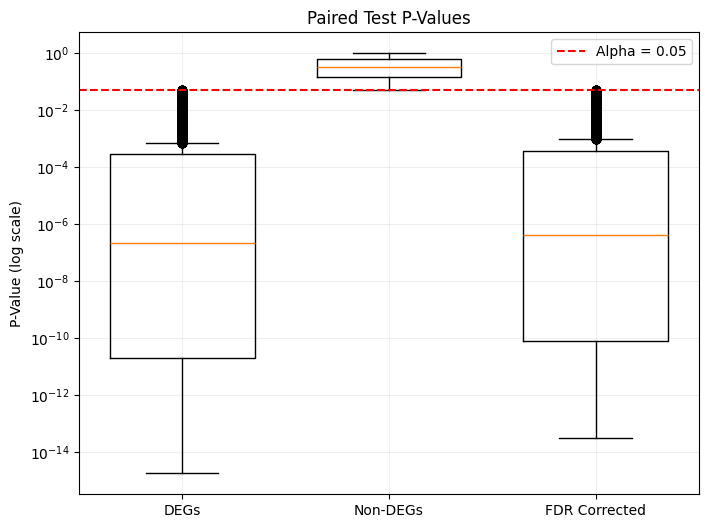

C:\Users\3m\AppData\Local\Temp\ipykernel_19060\1467154932.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(independent_pvalues,


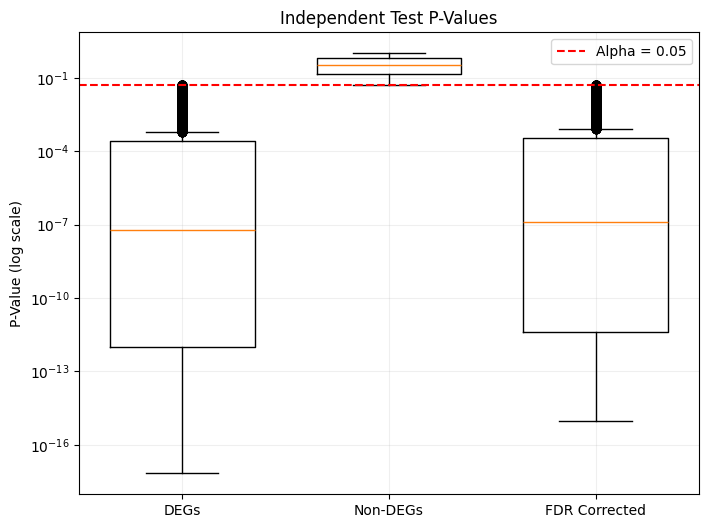

In [13]:
# Create boxplot for paired test results
plt.figure(figsize=(8, 6))
# Extract p-values for different categories
paired_pvalues = [
    [p for _, p in degs_paired],        # P-values for significant DEGs
    [p for _, p in non_degs_paired],    # P-values for non-significant genes
    [p for _, _, p in degs_paired_corrected]  # FDR-corrected p-values
]

# Generate boxplot with customized appearance
plt.boxplot(paired_pvalues, 
           labels=['DEGs', 'Non-DEGs', 'FDR Corrected'],
           widths=0.7)
plt.yscale('log')                       # Use log scale for better visualization
plt.title('Paired Test P-Values')
plt.ylabel('P-Value (log scale)')
plt.axhline(y=0.05, color='r', linestyle='--', label='Alpha = 0.05')  # Significance threshold
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)  # Add light grid for readability
plt.show()

# Create similar boxplot for independent test results
plt.figure(figsize=(8, 6))
independent_pvalues = [
    [p for _, p in degs_independent],    # P-values for significant DEGs
    [p for _, p in non_degs_independent],# P-values for non-significant genes
    [p for _, _, p in degs_independent_corrected]  # FDR-corrected p-values
]

# Generate boxplot with identical formatting
plt.boxplot(independent_pvalues, 
           labels=['DEGs', 'Non-DEGs', 'FDR Corrected'],
           widths=0.7)
plt.yscale('log')
plt.title('Independent Test P-Values')
plt.ylabel('P-Value (log scale)')
plt.axhline(y=0.05, color='r', linestyle='--', label='Alpha = 0.05')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

## Fold change


In [14]:
# Initialize lists to store fold change values for different categories
fc_values = []
non_significant_fc = []  # Genes below threshold
significant_fc = []      # Genes above threshold
all_genes_fc = []        # All genes regardless of significance

# Define analysis parameters
threshold = np.log2(1.5)  # Log2 fold change threshold (1.5x change)
epsilon = 1e-8           # Small value to handle zero expression levels

# Process expression data for each gene
for gene, expression_data in exprLung_data_filtered.items():
    # Extract expression levels for normal and cancerous samples
    normal_levels = expression_data['Normal']
    cancerous_levels = expression_data['Cancerous']

    # Replace zeros with epsilon to avoid division by zero
    normal_levels = np.where(normal_levels == 0, epsilon, normal_levels)
    cancerous_levels = np.where(cancerous_levels == 0, epsilon, cancerous_levels)

    # Calculate log2 fold change (cancer/normal)
    values = np.log2(np.divide(cancerous_levels, normal_levels))
    mean_fc = np.mean(values)  # Average fold change across samples

    # Categorize genes based on fold change magnitude
    if abs(mean_fc) < threshold:
        non_significant_fc.append((gene, mean_fc))
        all_genes_fc.append((gene, mean_fc))
    else:
        significant_fc.append((gene, mean_fc))
        all_genes_fc.append((gene, mean_fc))

# Display summary statistics
print(f"Number of DEGs by FC: {len(significant_fc)}")
print(f"Number of non-significant genes: {len(non_significant_fc)}")

# Create formatted table for top differentially expressed genes
table = PrettyTable()
table.field_names = ["Gene", "log2 FC"]

# Display top 5 genes with significant fold changes
for gene, values in significant_fc[:5]:
    table.add_row([gene, f"{values:.4f}"])

print("\nTop 5 Significant Genes by Fold Change:")
print(table)

# Store results in dictionary for downstream analysis
fold_change_results = {
    'significant': significant_fc,
    'non_significant': non_significant_fc,
    'all_genes': all_genes_fc,
    'threshold': threshold
}

Number of DEGs by FC: 9622
Number of non-significant genes: 7662

Top 5 Significant Genes by Fold Change:
+----------+---------+
|   Gene   | log2 FC |
+----------+---------+
| HIST3H2A |  1.9978 |
|   LXN    | -1.0493 |
|  CNKSR2  | -2.7531 |
|  GSDMD   | -0.5890 |
|  AKR1C1  |  1.4709 |
+----------+---------+


### Common


Common DEGs Analysis:
Number of significant genes by fold change: 9622
Number of significant genes by paired test (FDR corrected): 13375
Number of significant genes by independent test (FDR corrected): 13432

Number of common genes (Fold Change & Paired): 8898
Number of common genes (Fold Change & Independent): 9027


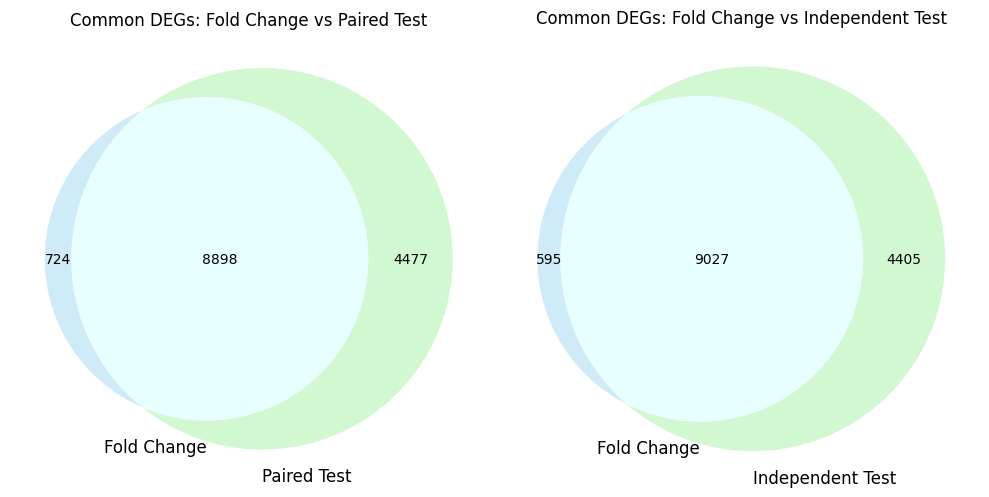


Example common genes (Fold Change & Paired):
+----------+---------+-------------------+
|   Gene   | Log2 FC | Corrected p-value |
+----------+---------+-------------------+
|  HSPB1   |  1.4669 |     9.2357e-12    |
|  RASSF5  | -1.0200 |     5.9463e-10    |
| MT-ND4L  | -0.6194 |     3.8899e-05    |
|   GPT2   |  2.3004 |     9.5775e-13    |
| C1orf186 | -2.5165 |     1.4284e-06    |
+----------+---------+-------------------+

Example common genes (Fold Change & Independent):
+----------+---------+-------------------+
|   Gene   | Log2 FC | Corrected p-value |
+----------+---------+-------------------+
|  HSPB1   |  1.4669 |     9.4519e-12    |
|  RASSF5  | -1.0200 |     1.7395e-11    |
| MT-ND4L  | -0.6194 |     5.8146e-06    |
|   GPT2   |  2.3004 |     1.3519e-14    |
| C1orf186 | -2.5165 |     2.6191e-10    |
+----------+---------+-------------------+


In [15]:
# Extract significant genes from each analysis method
fc_significant_genes = set(gene for gene, _ in significant_fc)
paired_significant_genes = set(gene for gene, _, corrected_p in degs_paired_corrected 
                             if corrected_p < 0.05)
independent_significant_genes = set(gene for gene, _, corrected_p in degs_independent_corrected 
                                  if corrected_p < 0.05)

# Find overlapping genes between fold change and statistical tests
common_genes_paired = fc_significant_genes.intersection(paired_significant_genes)
common_genes_independent = fc_significant_genes.intersection(independent_significant_genes)

# Display summary statistics of gene counts
print("Common DEGs Analysis:")
print(f"Number of significant genes by fold change: {len(fc_significant_genes)}")
print(f"Number of significant genes by paired test (FDR corrected): {len(paired_significant_genes)}")
print(f"Number of significant genes by independent test (FDR corrected): {len(independent_significant_genes)}")
print(f"\nNumber of common genes (Fold Change & Paired): {len(common_genes_paired)}")
print(f"Number of common genes (Fold Change & Independent): {len(common_genes_independent)}")

# Create side-by-side Venn diagrams
plt.figure(figsize=(10, 5))

# Venn diagram for fold change vs paired test
plt.subplot(1, 2, 1)
venn2([fc_significant_genes, paired_significant_genes], 
      set_labels=('Fold Change', 'Paired Test'),
      set_colors=('skyblue', 'lightgreen'))
plt.title('Common DEGs: Fold Change vs Paired Test')

# Venn diagram for fold change vs independent test
plt.subplot(1, 2, 2)
venn2([fc_significant_genes, independent_significant_genes], 
      set_labels=('Fold Change', 'Independent Test'),
      set_colors=('skyblue', 'lightgreen'))
plt.title('Common DEGs: Fold Change vs Independent Test')
plt.tight_layout()
plt.show()

# Display detailed information for example common genes
print("\nExample common genes (Fold Change & Paired):")
table_paired = PrettyTable()
table_paired.field_names = ["Gene", "Log2 FC", "Corrected p-value"]

# Show top 5 common genes between fold change and paired test
for gene in list(common_genes_paired)[:5]:
    fc_value = next(fc for g, fc in significant_fc if g == gene)
    p_value = next(p for g, _, p in degs_paired_corrected if g == gene)
    table_paired.add_row([gene, f"{fc_value:.4f}", f"{p_value:.4e}"])
print(table_paired)

print("\nExample common genes (Fold Change & Independent):")
table_independent = PrettyTable()
table_independent.field_names = ["Gene", "Log2 FC", "Corrected p-value"]

# Show top 5 common genes between fold change and independent test
for gene in list(common_genes_independent)[:5]:
    fc_value = next(fc for g, fc in significant_fc if g == gene)
    p_value = next(p for g, _, p in degs_independent_corrected if g == gene)
    table_independent.add_row([gene, f"{fc_value:.4f}", f"{p_value:.4e}"])
print(table_independent)

# Store results for downstream analysis
common_genes_results = {
    'paired': common_genes_paired,
    'independent': common_genes_independent
}

### Saving the results to a CSV file

In [16]:
# Define output file paths
csv_file_path_paired = 'common_genes_data_paired.csv'
csv_file_path_independent = 'common_genes_data_independent.csv'

# Export results for paired analysis
with open(csv_file_path_paired, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Gene", "Corrected P-value", "Log2 Fold Change"])
    
    # Write data for each gene found in both fold change and paired analysis
    for gene in common_genes_paired:
        fc_value = next(fc for g, fc in significant_fc if g == gene)
        p_value = next(p for g, _, p in degs_paired_corrected if g == gene)
        csv_writer.writerow([gene, f"{p_value:.4e}", f"{fc_value:.4f}"])

print(f"CSV file generated: {csv_file_path_paired}")

# Export results for independent analysis
with open(csv_file_path_independent, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Gene", "Corrected P-value", "Log2 Fold Change"])
    
    # Write data for each gene found in both fold change and independent analysis
    for gene in common_genes_independent:
        fc_value = next(fc for g, fc in significant_fc if g == gene)
        p_value = next(p for g, _, p in degs_independent_corrected if g == gene)
        csv_writer.writerow([gene, f"{p_value:.4e}", f"{fc_value:.4f}"])

print(f"CSV file generated: {csv_file_path_independent}")

CSV file generated: common_genes_data_paired.csv
CSV file generated: common_genes_data_independent.csv


### Verifying results

In [17]:
# Read the CSV file
df_paired = pd.read_csv('common_genes_data_paired.csv')
df_independent = pd.read_csv('common_genes_data_independent.csv')
# Inspect the data
print(df_paired.head())
print(df_independent.head())


       Gene  Corrected P-value  Log2 Fold Change
0     HSPB1       9.235700e-12            1.4669
1    RASSF5       5.946300e-10           -1.0200
2   MT-ND4L       3.889900e-05           -0.6194
3      GPT2       9.577500e-13            2.3004
4  C1orf186       1.428400e-06           -2.5165
       Gene  Corrected P-value  Log2 Fold Change
0     HSPB1       9.451900e-12            1.4669
1    RASSF5       1.739500e-11           -1.0200
2   MT-ND4L       5.814600e-06           -0.6194
3      GPT2       1.351900e-14            2.3004
4  C1orf186       2.619100e-10           -2.5165


In [18]:
# Add a "Ranking" column to the DataFrame
df_paired['Ranking'] = -np.log10(df_paired['Corrected P-value']) * df_paired['Log2 Fold Change']
# Sort the DataFrame by the "Ranking" column in descending order
df_paired_sorted = df_paired.sort_values(by='Ranking', ascending=False).reset_index(drop=True)
# Extract the ranking DataFrame
ranking_paired = df_paired_sorted[['Gene', 'Ranking']]
print(ranking_paired.head())

     Gene     Ranking
0  RAET1L  236.427685
1  GABRA3  196.555939
2   USH1G  189.802666
3   SPERT  189.446678
4   BARX1  185.957135


In [19]:
# Read the CSV file into a DataFrame
df_paired = pd.read_csv('common_genes_data_paired.csv')
# Add a "Ranking" column to the DataFrame
df_paired['Ranking'] = -np.log10(df_paired['Corrected P-value']) * df_paired['Log2 Fold Change']
# Sort the DataFrame by the "Ranking" column in descending order
df_paired_sorted = df_paired.sort_values(by='Ranking', ascending=False).reset_index(drop=True)
df_paired_sorted

,Gene,Corrected P-value,Log2 Fold Change,Ranking
0,RAET1L,3.093600e-14,17.5008,236.427685
1,GABRA3,8.389400e-14,15.0315,196.555939
2,USH1G,1.474800e-13,14.7922,189.802666
3,SPERT,4.051900e-13,15.2874,189.446678
4,BARX1,1.474800e-13,14.4925,185.957135
...,...,...,...,...
8893,RBP2,3.093600e-14,-15.4411,-208.602094
8894,TMEM252,8.389400e-14,-16.1364,-211.003909
8895,AGBL1,3.093600e-14,-15.9421,-215.370371
8896,PLA2G12B,4.201400e-14,-16.1688,-216.283667


In [20]:
ranking_paired = df_paired_sorted[['Gene', 'Ranking']]
ranking_paired

,Gene,Ranking
0,RAET1L,236.427685
1,GABRA3,196.555939
2,USH1G,189.802666
3,SPERT,189.446678
4,BARX1,185.957135
...,...,...
8893,RBP2,-208.602094
8894,TMEM252,-211.003909
8895,AGBL1,-215.370371
8896,PLA2G12B,-216.283667


In [21]:
gp.get_library_name()
pre_res_paired = gp.prerank(rnk=ranking_paired, gene_sets='Cancer_Cell_Line_Encyclopedia', seed=6, permutation_num=100)
pre_res_paired
out_paired = []

for term in list(pre_res_paired.results):
    out_paired.append([term,
                       pre_res_paired.results[term]['fdr'],
                       pre_res_paired.results[term]['es'],
                       pre_res_paired.results[term]['nes']])

# fdr: False discovery rate.
# es: Enrichment score.
# nes: Normalized enrichment score.

out_paired_df = pd.DataFrame(out_paired, columns=['Term', 'fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop=True)
out_paired_df

2024-12-31 22:20:56,756 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes
0,LUDLU1 LUNG,0.000000,0.589317,2.142019
1,P31FUJ HAEMATOPOIETIC AND LYMPHOID TISSUE,0.000000,-0.608712,-2.125349
2,SNU503 LARGE INTESTINE,0.000000,0.749980,2.839857
3,NCCSTCK140 STOMACH,0.000000,0.508461,2.077610
4,BICR6 UPPER AERODIGESTIVE TRACT,0.000000,0.715241,2.616414
...,...,...,...,...
950,AMO1 HAEMATOPOIETIC AND LYMPHOID TISSUE,0.930677,0.210105,0.743794
951,SNU489 CENTRAL NERVOUS SYSTEM,0.942748,-0.220378,-0.696837
952,LCLC103H LUNG,0.954029,-0.255125,-0.679890
953,EBC1 LUNG,0.956127,0.210412,0.701605


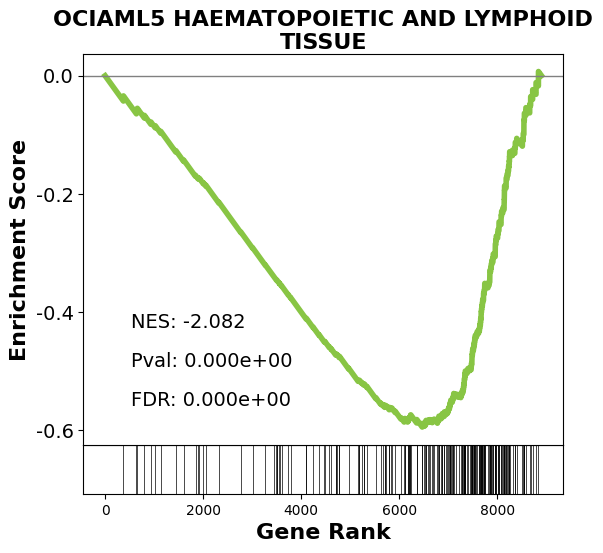

In [26]:

# Specify the gene set term you want to visualize
gene_set_term = "OCIAML5 HAEMATOPOIETIC AND LYMPHOID TISSUE"

# Plot the GSEA results for the specific gene set term "NCIH1651 LUNG"
gseaplot(ranks=pre_res_paired.ranking, term=gene_set_term, **pre_res_paired.results[gene_set_term])

# Show the plot
plt.show()

# Volcano Plot

In [23]:
# Create a dictionary for log2 fold change values with genes as keys
fc_dict = dict(all_genes_fc)

# Initialize a list to store corrected p and log2 fold change values
volcano_data = []

# Iterate through the genes with corrected p-values
for gene, paired_p_values, corrected_p_values_paired  in degs_paired_corrected:
    # Find the log2 fold change values for the gene using the dictionary
    if gene in fc_dict:
        values = fc_dict[gene]
        # Append gene, corrected p-value, and log2 fold change to the list
        volcano_data.append((gene, corrected_p_values_paired, values))

# Print the first few rows of the volcano data using PrettyTable
table = PrettyTable()
table.field_names = ["Gene", "Corrected P-value", "Log2 Fold Change"]

for gene, corrected_p_values_paired, log2_fold_change in volcano_data[:10]:
    table.add_row([gene, f"{corrected_p_values_paired:.2e}", f"{log2_fold_change:.4f}"])

print(table)


+----------+-------------------+------------------+
|   Gene   | Corrected P-value | Log2 Fold Change |
+----------+-------------------+------------------+
| HIST3H2A |      1.02e-10     |      1.9978      |
|   LXN    |      4.57e-07     |     -1.0493      |
|  CNKSR2  |      1.63e-10     |     -2.7531      |
|  SCML1   |      1.65e-02     |     -0.4442      |
|  GSDMD   |      3.75e-07     |     -0.5890      |
|  AKR1C1  |      9.00e-05     |      1.4709      |
| C3orf62  |      1.01e-07     |     -0.7283      |
| CRISPLD2 |      5.93e-07     |     -1.1424      |
|  DOCK5   |      7.57e-06     |     -0.8118      |
| SLC33A1  |      2.20e-11     |      0.7729      |
+----------+-------------------+------------------+


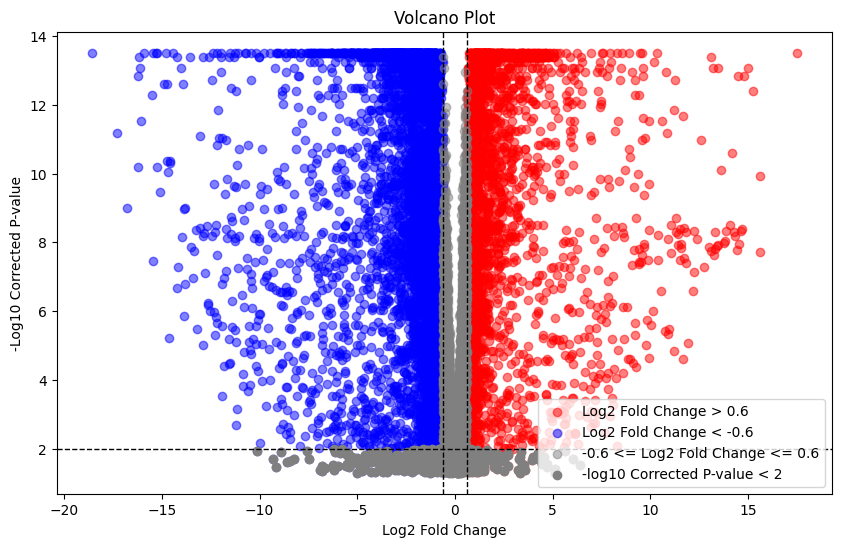

In [24]:
# Unpack the data for plotting
genes, corrected_p_values, log2_fold_changes = zip(*volcano_data)

# Set a significance threshold (you can adjust this)
significance_threshold = 0.05

# Determine the direction of log2 fold change
# total_indices=[i for i, p_value in enumerate(-np.log10(corrected_p_values))]
left_indices = [i for i, fold_change in enumerate(log2_fold_changes) if fold_change > 0.6]
right_indices = [i for i, fold_change in enumerate(log2_fold_changes) if fold_change < -0.6]
gray_indices = [i for i, fold_change in enumerate(log2_fold_changes) if -0.6 < fold_change < 0.6]
low_p_value_indices = [i for i, p_value in enumerate(-np.log10(corrected_p_values)) if p_value < 2]

# Plot the volcano plot
plt.figure(figsize=(10, 6))
# plt.scatter(np.array(log2_fold_changes)[total_indices], -np.log10(np.array(corrected_p_values)[total_indices]), c='black', label='Log2 Fold Change > 0.6', alpha=1)
# Plot left points in red
plt.scatter(np.array(log2_fold_changes)[left_indices], -np.log10(np.array(corrected_p_values)[left_indices]), c='red', label='Log2 Fold Change > 0.6', alpha=0.5)

# Plot right points in blue
plt.scatter(np.array(log2_fold_changes)[right_indices], -np.log10(np.array(corrected_p_values)[right_indices]), c='blue', label='Log2 Fold Change < -0.6', alpha=0.5)

# Plot gray points between -1 and 1 in gray
plt.scatter(np.array(log2_fold_changes)[gray_indices], -np.log10(np.array(corrected_p_values)[gray_indices]), c='gray', label='-0.6 <= Log2 Fold Change <= 0.6', alpha=0.5)

# Highlight points with -log10(corrected p-values) below 2 in gray
plt.scatter(np.array(log2_fold_changes)[low_p_value_indices], -np.log10(np.array(corrected_p_values)[low_p_value_indices]), c='gray', label='-log10 Corrected P-value < 2', alpha=1)
# Add dashed lines to separate regions
plt.axvline(x=-0.6, color='k', linestyle='--', linewidth=1)
plt.axvline(x=0.6, color='k', linestyle='--', linewidth=1)
plt.axhline(y=2, color='k', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Corrected P-value')
plt.title('Volcano Plot')
plt.legend()

# Show the plot
plt.show()
